# Criação de um Algoritmo de Clustering para Alertas

## Introdução e Objetivo

Bom, essa é a que eu considero a parte um pouco mais "abstrata" e experimental do relatório, a nossa idéia original era:

* Receber uma lista de alertas a cada 60min da API Java (com suas localizações e, idealmente, suas classificações de severidade/tipo já feitas de acordo com a pipeline do notebook anterior '02_Evaluate_Risk_Classifier') e agrupá-los para identificar hotspots de desastres, retornando um sumário de cada hotspot por hora, já que o objetivo do app é ser sobre alertas rápidos e evitar riscos imediatos, o acompanhamento de desastres que se formam lentamente durante um longo periodo de tempo está fora do escopo inicial do app, apesar de ser sim possível a análise de dados históricos após certo tempo de operação (ou seja, ser capaz de identificar um espaço geográfico em comum onde estão sendo emitidos muitos alertas parecidos e devolver essa lista de hotspots, ou ser capaz de devolver uma lista vazia, se não houverem clusters relevantes, importante para garantir que há uma lógica por trás da identificação dos hotspots)

Ao começar a trabalhar com esas idéia porém eu encontrei dois grandes desafios:

* Viabilidade do Clustering e Dados: estava preocupado com a falta de uma boa base de dados para ver o clustering em ação mesmo com dados sintéticos (já que é o tipo de funcionalidade a ser implementada idealmente em um aplicativo que já esta operando a um tempo e tem dados históricos para o treinamento)
* O DBSCAN (da maneira que eu estava pensando inicialmente) vai clusterizar unicamente por proximidade geográfica, como adicionar uma "lógica de evento" (além da geográfica) para o tramento desses clusters que são basicamente aglomerados geográficos de eventos potencialmente diversos?

Depois de pensar bastante cheguei a conclusão que o objetivo do teste inicial não deveria ser validar a precisão estatística dos hotspots (impossível pela carência de dados reais), mas sim validar a pipeline de código:

* A API Python recebe os dados corretamente?
* As coordenadas são extraídas?
* O DBSCAN é executado sem erros?
* Eu consigo calcular centroides e agregar as informações (tipo/severidade predominante) dos alertas em cada cluster formado?

## Configuração Inicial

**Tecnologias Aplicadas Nesta Etapa:**

* Shapely: Lib utilizada para manipulação e análise de objetos geométricos planares, como os polígonos que definem as áreas de interesse e os pontos que representam os alertas
* NumPy: No manuseio de arrays e matrizes
* Pandas: Para a estruturação e manipulação dos dados dos alertas
* Scikit-learn (sklearn.cluster.DBSCAN): Biblioteca de machine learning utilizada para aplicar o algoritmo de clustering DBSCAN, responsável por agrupar os alertas geograficamente e identificar hotspots
* Folium: Usado para a visualização interativa dos alertas e dos clusters gerados em mapas reais, permitindo uma análise geográfica intuitiva dos resultados

In [ ]:
!pip install Shapely -q

In [ ]:
from shapely.geometry import Point, Polygon
import random
import numpy as np
import folium
import os
import pandas as pd
from IPython.display import display
from sklearn.cluster import DBSCAN
from collections import Counter
from typing import List, Dict, Tuple, Optional
from sklearn.metrics.pairwise import haversine_distances
from datetime import datetime, timezone
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/Colab_Notebooks'
PROJECT_FOLDER_NAME = 'AlertaVermelho_AI'
project_base_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, PROJECT_FOLDER_NAME)
dataset_path = os.path.join(project_base_path, 'Datasets/dataset_para_clustering.csv')

## Montagem de um Dataset para validação da pipeline

A ideia para essa etapa é montar um pequeno dataset sintético para testar clustering, mesmo com a geração de poucos dados (50-100 alertas), da pra ver o DBSCAN em ação. O importante é que os dados tenham coordenadas geográficas minimamente realistas e agrupamentos (hotspots) intencionamente criados que eu espero que o DBSCAN encontre, (importante variar os tipos e severidades dentro e entre eles para testar a lógica de sumarização)

Para garantir o máximo de veracidade possível ustilizei o website GeoJSON: https://geojson.io/ , esse website permite desenhar um polígono em um mapa bi-dimensional e gera as coodenadas geográficas (longitude, latitude) de cada ponto que compõe o polígono em formato JSON, trabalharemos com um circulo de 1,5km de raio, pois é a área que planejamos para o front end mostrar os alertas no mapa para um usuário.

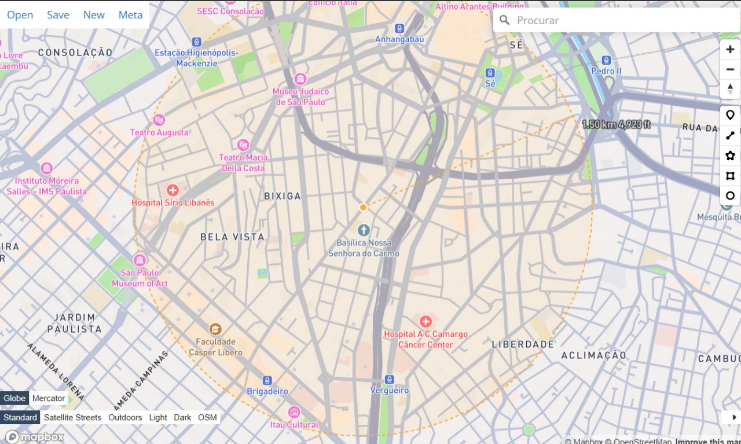


In [ ]:
# Começar mapeando as cordenadas para um array (formato longitude, latitude)
coordinates = [
  [-46.642427427925924, -23.54498580232752], [-46.643865779357895, -23.545050574540255],
  [-46.64529028289741,  -23.54524426757701],  [-46.64668722385282,  -23.545565016631773],
  [-46.648043152657515, -23.546009733631386], [-46.64934501425295,  -23.546574136940258],
  [-46.65058027369024,  -23.547252792547564], [-46.651737036745146, -23.54803916634203],
  [-46.652804164389146, -23.54892568697327],  [-46.65377138001696,  -23.549903818696578],
  [-46.6546293683998,   -23.550964143502608], [-46.655369865411885, -23.55209645174361],
  [-46.65598573766555,  -23.553289840386512], [-46.65647105128635,  -23.554532817949184],
  [-46.656821129162616, -23.55581341511194],  [-46.65703259611443,  -23.557119299941178],
  [-46.657103411542046, -23.55843789661739],  [-46.6570328892338,   -23.559756506525364],
  [-46.656821704136945, -23.561062430541412], [-46.656471886019695, -23.56234309134008],
  [-46.65598680007958,  -23.563586154542286], [-46.65537111467862,  -23.564779647537264],
  [-46.65463075651064,  -23.565912074832696], [-46.65377285362758,  -23.566972528820305],
  [-46.65280566686951,  -23.567950794887974], [-46.65173851035579,  -23.568837449863572],
  [-46.65058166180113,  -23.569623952839628], [-46.64934626351974,  -23.570302727501364],
  [-46.64804421507161,  -23.57086723516232],  [-46.64668805858623,  -23.571312037801473],
  [-46.64529085787177,  -23.571632850492154], [-46.64386607247728,  -23.57182658271572],
  [-46.642427427925924, -23.571891368160216], [-46.64098878337456,  -23.57182658271572],
  [-46.63956399798007,  -23.571632850492154], [-46.63816679726562,  -23.571312037801473],
  [-46.63681064078024,  -23.57086723516232],  [-46.635508592332094, -23.570302727501364],
  [-46.634273194050714, -23.569623952839628], [-46.63311634549605,  -23.568837449863572],
  [-46.63204918898233,  -23.567950794887974], [-46.63108200222426,  -23.566972528820305],
  [-46.6302240993412,   -23.565912074832696], [-46.62948374117321,  -23.564779647537264],
  [-46.62886805577226,  -23.563586154542286], [-46.628382969832145, -23.56234309134008],
  [-46.628033151714895, -23.561062430541412], [-46.62782196661804,  -23.559756506525364],
  [-46.627751444309794, -23.55843789661739],  [-46.6278222597374,   -23.557119299941178],
  [-46.628033726689225, -23.55581341511194],  [-46.628383804565495, -23.554532817949184],
  [-46.62886911818629,  -23.553289840386512], [-46.629484990439956, -23.55209645174361],
  [-46.63022548745203,  -23.550964143502608], [-46.63108347583487,  -23.549903818696578],
  [-46.6320506914627,   -23.54892568697327],  [-46.63311781910669,  -23.54803916634203],
  [-46.634274582161595, -23.547252792547564], [-46.63550984159888,  -23.546574136940258],
  [-46.636811703194326, -23.546009733631386], [-46.638167631999,    -23.545565016631773],
  [-46.63956457295442,  -23.54524426757701],  [-46.640989076493945, -23.545050574540255],
  [-46.642427427925924, -23.54498580232752]
]

In [ ]:
# Shapely converte as coordenadas para um polígono
area_circular_definida = Polygon(coordinates)

In [ ]:
# Função para gerar clusters de alertas dentro do polígono (DBSCAN deveria conseguir interpretar esses alertas como clusters separados)
def gerar_config_hotspots_dinamico(
  area_limite_polygon,
  num_hotspots_distintos_desejados,
  num_pares_proximos_desejados, # config para gerar 2 hotspots proximos geograficamente e ver como o DBSCAN vai se comportar
  fator_raio_geracao_centros, # % do raio aprox da área limite para posicionar centros
  distancia_entre_par_graus, # distancia para separar o par próximo
  distancia_min_entre_centros_base_graus, # distância mínima entre os centros
  alertas_por_hotspot_range, # (min, max) de alertas por hotspot
  raio_dispersao_hotspot_graus_range # (min, max)
):
  """
  Gera configurações para múltiplos hotspots, incluindo pares próximos,
  dentro de um polígono limite.
  """
  configs_com_id_temp = []
  centros_ja_posicionados = []

  centroide_principal = area_limite_polygon.centroid
  min_lon, min_lat, max_lon, max_lat = area_limite_polygon.bounds

  raio_aprox_principal_lon = (max_lon - min_lon) / 2
  raio_aprox_principal_lat = (max_lat - min_lat) / 2
  raio_base_para_posicionar_centros = min(raio_aprox_principal_lon, raio_aprox_principal_lat) * fator_raio_geracao_centros

  tentativas_geracao_centro = 30

  num_centros_base_a_gerar = num_hotspots_distintos_desejados + num_pares_proximos_desejados
  if num_centros_base_a_gerar == 0:
    return []

  angulos_base = np.linspace(0, 2 * np.pi, num_centros_base_a_gerar, endpoint=False)
  random.shuffle(angulos_base)

  # 1 - Gerar centros para hotspots distintos
  print(f"Tentando gerar {num_centros_base_a_gerar} centros base")
  for i in range(num_centros_base_a_gerar):
    posicao_encontrada_para_base = False
    centro_lon_candidato, centro_lat_candidato = -1.0, -1.0
    for _ in range(tentativas_geracao_centro):
      r = raio_base_para_posicionar_centros * random.uniform(0.7, 1.1)
      variacao_angular = np.pi / (num_centros_base_a_gerar * 3 + 1)
      angulo = angulos_base[i] + random.uniform(-variacao_angular, variacao_angular)

      temp_lon = centroide_principal.x + r * np.cos(angulo)
      temp_lat = centroide_principal.y + r * np.sin(angulo)
      ponto_centro = Point(temp_lon, temp_lat)

      if not area_limite_polygon.contains(ponto_centro):
        continue

      muito_perto_de_outro_base = any(
        np.hypot(c_lon - temp_lon, c_lat - temp_lat) < distancia_min_entre_centros_base_graus
        for c_lon, c_lat in centros_ja_posicionados
      )

      if not muito_perto_de_outro_base:
        centro_lon_candidato, centro_lat_candidato = temp_lon, temp_lat
        posicao_encontrada_para_base = True
        break

    if posicao_encontrada_para_base:
      centros_ja_posicionados.append((centro_lon_candidato, centro_lat_candidato))
      configs_com_id_temp.append({
        "id_temp_idx": i,
        "centro_lat": centro_lat_candidato, "centro_lon": centro_lon_candidato,
        "num_alertas": random.randint(*alertas_por_hotspot_range),
        "raio_dispersao_graus": random.uniform(*raio_dispersao_hotspot_graus_range)
      })
      print(f"Centro base com id_temp_idx={i} posicionado com sucesso.")
    else:
      print(f"Não foi possível posicionar o centro base com id_temp_idx={i} após {tentativas_geracao_centro} tentativas.")

  # 2 - Gerar o segundo hotspot de cada par próximo
  print(f"\nProcessando {len(configs_com_id_temp)} centros base gerados")
  configs_finais_retorno = []

  for i in range(num_hotspots_distintos_desejados):
    if i < len(configs_com_id_temp):
      config = configs_com_id_temp[i]
      config["id"] = f"Hotspot_Distinto_{i+1}"
      if "id_temp_idx" in config: del config["id_temp_idx"]
      configs_finais_retorno.append(config)
    else:
      print(f"Faltou centro base para o Hotspot_Distinto_{i+1}")

  for i in range(num_pares_proximos_desejados):
    indice_par_A_na_lista_temp = num_hotspots_distintos_desejados + i
    if indice_par_A_na_lista_temp < len(configs_com_id_temp):
      config_par_A = configs_com_id_temp[indice_par_A_na_lista_temp]
      config_par_A["id"] = f"Hotspot_Par_{i+1}A"
      if "id_temp_idx" in config_par_A: del config_par_A["id_temp_idx"]
      configs_finais_retorno.append(config_par_A)

      centro_a_lon = config_par_A["centro_lon"]
      centro_a_lat = config_par_A["centro_lat"]

      posicao_b_encontrada = False
      centro_b_lon_final, centro_b_lat_final = -1.0, -1.0

      for _ in range(tentativas_geracao_centro):
        angulo_offset_par = random.uniform(0, 2 * np.pi)

        temp_b_lon = centro_a_lon + distancia_entre_par_graus * np.cos(angulo_offset_par)
        temp_b_lat = centro_a_lat + distancia_entre_par_graus * np.sin(angulo_offset_par)
        ponto_centro_b = Point(temp_b_lon, temp_b_lat)

        if not area_limite_polygon.contains(ponto_centro_b):
          continue

        muito_perto_de_outro = any(
          np.hypot(cfg_existente["centro_lon"] - temp_b_lon, cfg_existente["centro_lat"] - temp_b_lat) < distancia_min_entre_centros_base_graus
          for cfg_existente in configs_finais_retorno
        )
        dist_do_par_A = np.hypot(centro_a_lon - temp_b_lon, centro_a_lat - temp_b_lat)

        if not muito_perto_de_outro or (dist_do_par_A < distancia_entre_par_graus * 1.1 and dist_do_par_A > distancia_entre_par_graus * 0.9) :
          if dist_do_par_A > 0.00001:
            centro_b_lon_final, centro_b_lat_final = temp_b_lon, temp_b_lat
            posicao_b_encontrada = True
            break

      if posicao_b_encontrada:
        configs_finais_retorno.append({
          "id": f"Hotspot_Par_{i+1}B",
          "centro_lat": centro_b_lat_final, "centro_lon": centro_b_lon_final,
          "num_alertas": random.randint(*alertas_por_hotspot_range),
          "raio_dispersao_graus": random.uniform(*raio_dispersao_hotspot_graus_range)
        })
        print(f"Hotspot Par {i+1}B posicionado com sucesso.")
      else:
        print(f"Não foi possível posicionar o segundo hotspot do par {i+1}B após {tentativas_geracao_centro} tentativas.")
    else:
      print(f"Faltou centro base para o Hotspot_Par_{i+1}A (índice temp {indice_par_A_na_lista_temp} não encontrado).")

  return configs_finais_retorno

In [ ]:
config_hotspots_gerados = gerar_config_hotspots_dinamico(area_circular_definida, 3, 1, 0.6, 0.009, 0.0030, (9, 15), (0.0015, 0.0020))
print(f"\nConfigurações de Hotspots Geradas Dinamicamente ({len(config_hotspots_gerados)} hotspots):")
for cfg in config_hotspots_gerados:
  print(cfg)

Tentando gerar 4 centros base
Centro base com id_temp_idx=0 posicionado com sucesso.
Centro base com id_temp_idx=1 posicionado com sucesso.
Centro base com id_temp_idx=2 posicionado com sucesso.
Centro base com id_temp_idx=3 posicionado com sucesso.

Processando 4 centros base gerados
Hotspot Par 1B posicionado com sucesso.

Configurações de Hotspots Geradas Dinamicamente (5 hotspots):
{'centro_lat': np.float64(-23.559006387330463), 'centro_lon': np.float64(-46.636251342537854), 'num_alertas': 13, 'raio_dispersao_graus': 0.0019225874049034666, 'id': 'Hotspot_Distinto_1'}
{'centro_lat': np.float64(-23.566476178708765), 'centro_lon': np.float64(-46.64114393010742), 'num_alertas': 14, 'raio_dispersao_graus': 0.0016000738791010194, 'id': 'Hotspot_Distinto_2'}
{'centro_lat': np.float64(-23.550859214555086), 'centro_lon': np.float64(-46.64061092054594), 'num_alertas': 13, 'raio_dispersao_graus': 0.0019510523216040483, 'id': 'Hotspot_Distinto_3'}
{'centro_lat': np.float64(-23.56004039369239),

In [ ]:
# Função para gerar alertas aleatórios dentro do polígono (DBSCAN deveria conseguir interpretar esses alertas como ruídos/outliars)
def gerar_alertas_isolados_com_distanciamento(
  num_alertas,
  poligono_limite,
  min_lon, min_lat, max_lon, max_lat,
  configs_hotspots_existentes, # Lista de dicts com 'centro_lon' e 'centro_lat'
  distancia_min_dos_centros_hotspot_graus
):
  """
  Gera configurações para hotspots isolados dentro de um polígono limite.
  """
  alertas_isolados_gerados = []
  tentativas_max = num_alertas * 20

  while len(alertas_isolados_gerados) < num_alertas and tentativas_max > 0:
    random_lon = random.uniform(min_lon, max_lon)
    random_lat = random.uniform(min_lat, max_lat)
    ponto_teste = Point(random_lon, random_lat)

    if poligono_limite.contains(ponto_teste):
      muito_perto_de_hotspot = False
      for config_hotspot in configs_hotspots_existentes:
        dist_ao_centro_hotspot = np.hypot(
          config_hotspot['centro_lon'] - random_lon,
          config_hotspot['centro_lat'] - random_lat
        )

        if dist_ao_centro_hotspot < distancia_min_dos_centros_hotspot_graus:
          muito_perto_de_hotspot = True
          break

      if not muito_perto_de_hotspot:
        alertas_isolados_gerados.append({'latitude': random_lat, 'longitude': random_lon})

    tentativas_max -=1

  if tentativas_max == 0 and len(alertas_isolados_gerados) < num_alertas:
    print(f"Aviso: Não foi possível gerar todos os {num_alertas} alertas isolados (com distanciamento) após várias tentativas.")

  return alertas_isolados_gerados

In [ ]:
# pregando os limites (bounding box) do polígono original
min_lon, min_lat, max_lon, max_lat = area_circular_definida.bounds

alert_coords_isolados = gerar_alertas_isolados_com_distanciamento(10, area_circular_definida, min_lon, min_lat, max_lon, max_lat,  config_hotspots_gerados, 0.0015)

print(f"\n{len(alert_coords_isolados)} Alertas Isolados Gerados (com distanciamento):")
if alert_coords_isolados:
  for i, alerta in enumerate(alert_coords_isolados):
    print(f"  Isolado {i+1}: Latitude={alerta['latitude']:.6f}, Longitude={alerta['longitude']:.6f}")


10 Alertas Isolados Gerados (com distanciamento):
  Isolado 1: Latitude=-23.563021, Longitude=-46.653035
  Isolado 2: Latitude=-23.556951, Longitude=-46.640417
  Isolado 3: Latitude=-23.563163, Longitude=-46.655469
  Isolado 4: Latitude=-23.561544, Longitude=-46.632029
  Isolado 5: Latitude=-23.559522, Longitude=-46.634166
  Isolado 6: Latitude=-23.558176, Longitude=-46.638833
  Isolado 7: Latitude=-23.551190, Longitude=-46.651908
  Isolado 8: Latitude=-23.548708, Longitude=-46.643296
  Isolado 9: Latitude=-23.564583, Longitude=-46.634810
  Isolado 10: Latitude=-23.547719, Longitude=-46.649334


Gerando as coordenadas (lon, lat) para cada alerta dentro dos hotspots definidos anteriormente:

In [ ]:
# Função para gerar os pontos de alerta para UM hotspot específico
def gerar_pontos_de_um_hotspot(centro_lat, centro_lon, num_alertas, raio_dispersao_graus, poligono_limite):
  """
  Gera as coordenadas (latitude, longitude) para um número específico de alertas
  em torno de um centro de hotspot, dentro de um polígono limite.
  """
  alertas_gerados_neste_hotspot = []
  tentativas_max = num_alertas * 5

  while len(alertas_gerados_neste_hotspot) < num_alertas and tentativas_max > 0:
    offset_lat = random.uniform(-raio_dispersao_graus, raio_dispersao_graus)
    offset_lon = random.uniform(-raio_dispersao_graus, raio_dispersao_graus)

    alerta_lat = centro_lat + offset_lat
    alerta_lon = centro_lon + offset_lon

    ponto_alerta = Point(alerta_lon, alerta_lat)

    if poligono_limite.contains(ponto_alerta):
      alertas_gerados_neste_hotspot.append({'latitude': alerta_lat, 'longitude': alerta_lon})

    tentativas_max -= 1

  if tentativas_max == 0 and len(alertas_gerados_neste_hotspot) < num_alertas:
    print(f"Não foi possível gerar todos os {num_alertas} alertas para o hotspot centrado em ({centro_lat:.5f}, {centro_lon:.5f}). Gerados: {len(alertas_gerados_neste_hotspot)}")

  return alertas_gerados_neste_hotspot

In [ ]:
# Gerando os alertas para os hotspots
todos_alertas_para_plotar = []
cores_hotspots_plot = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'darkgreen', 'cadetblue']
idx_cor_plot = 0

# Gerando coordenadas dos alertas para cada hotspot
for config_h in config_hotspots_gerados:
  print(f"  Gerando alertas para o hotspot: {config_h.get('id', 'ID_Nao_Definido')}")

  coordenadas_deste_hotspot = gerar_pontos_de_um_hotspot(
    config_h["centro_lat"],
    config_h["centro_lon"],
    config_h["num_alertas"],
    config_h["raio_dispersao_graus"],
    area_circular_definida
  )

  cor_atual_hotspot = cores_hotspots_plot[idx_cor_plot % len(cores_hotspots_plot)]
  for coord in coordenadas_deste_hotspot:
    todos_alertas_para_plotar.append({
      **coord,
      "grupo": config_h.get('id', f'Hotspot_{idx_cor_plot+1}'),
      "cor": cor_atual_hotspot
    })

  if coordenadas_deste_hotspot:
    idx_cor_plot += 1

# Adicionar os alertas isolados
for coord in alert_coords_isolados:
  todos_alertas_para_plotar.append({**coord, "grupo": "Ruído/Isolado", "cor": "gray"})

print(f"\nTotal de {len(todos_alertas_para_plotar)} pontos de alerta prontos para plotar")

  Gerando alertas para o hotspot: Hotspot_Distinto_1
  Gerando alertas para o hotspot: Hotspot_Distinto_2
  Gerando alertas para o hotspot: Hotspot_Distinto_3
  Gerando alertas para o hotspot: Hotspot_Par_1A
  Gerando alertas para o hotspot: Hotspot_Par_1B

Total de 76 pontos de alerta prontos para plotar


Importante printar as coodenadas geográficas de cada alerta inidivudal

In [ ]:
lista_completa_coords_hotspots = []

for config_item in config_hotspots_gerados:
  hotspot_id_atual = config_item.get('id', 'ID_Nao_Especificado')

  coordenadas_para_este_hotspot = gerar_pontos_de_um_hotspot(
    config_item["centro_lat"],
    config_item["centro_lon"],
    config_item["num_alertas"],
    config_item["raio_dispersao_graus"],
    area_circular_definida
  )

  print(f"\nAlertas Gerados para {hotspot_id_atual}:")
  for i, coordenada_alerta in enumerate(coordenadas_para_este_hotspot):
    print(f"Alerta {i+1}: Latitude={coordenada_alerta['latitude']:.6f}, Longitude={coordenada_alerta['longitude']:.6f}")
  lista_completa_coords_hotspots.extend(coordenadas_para_este_hotspot)


Alertas Gerados para Hotspot_Distinto_1:
Alerta 1: Latitude=-23.557494, Longitude=-46.637053
Alerta 2: Latitude=-23.560501, Longitude=-46.637243
Alerta 3: Latitude=-23.557553, Longitude=-46.637237
Alerta 4: Latitude=-23.558925, Longitude=-46.637643
Alerta 5: Latitude=-23.559198, Longitude=-46.635964
Alerta 6: Latitude=-23.558017, Longitude=-46.635151
Alerta 7: Latitude=-23.560646, Longitude=-46.636932
Alerta 8: Latitude=-23.559451, Longitude=-46.637012
Alerta 9: Latitude=-23.559845, Longitude=-46.637824
Alerta 10: Latitude=-23.558401, Longitude=-46.636214
Alerta 11: Latitude=-23.559315, Longitude=-46.636686
Alerta 12: Latitude=-23.559616, Longitude=-46.636044
Alerta 13: Latitude=-23.560200, Longitude=-46.635635

Alertas Gerados para Hotspot_Distinto_2:
Alerta 1: Latitude=-23.566611, Longitude=-46.640675
Alerta 2: Latitude=-23.566822, Longitude=-46.642502
Alerta 3: Latitude=-23.567268, Longitude=-46.641498
Alerta 4: Latitude=-23.566872, Longitude=-46.640210
Alerta 5: Latitude=-23.56655

Agora plotando com folium para visulizar melhor:

In [ ]:
# pegar o centroide do polígono original
mapa_centro_lat = area_circular_definida.centroid.y
mapa_centro_lon = area_circular_definida.centroid.x

# Criar o mapa
mapa_visualizacao_final = folium.Map(location=[mapa_centro_lat, mapa_centro_lon], zoom_start=15)
coords_para_geojson = [[[lon, lat] for lon, lat in area_circular_definida.exterior.coords]]
folium.GeoJson(
  {"type": "Polygon", "coordinates": coords_para_geojson},
  name="Área circular de 1.5km de raio",
  style_function=lambda x: {'fillColor': '#DDDDDD', 'color': '#AAAAAA', 'weight': 2, 'fillOpacity': 0.2}
).add_to(mapa_visualizacao_final)

# Adicionar os alertas (hotspots e isolados)
for alerta_plot in todos_alertas_para_plotar:
  folium.CircleMarker(
    location=[alerta_plot['latitude'], alerta_plot['longitude']],
    radius=5, # Tamanho do marcador do ponto
    color=alerta_plot['cor'],
    fill=True,
    fill_color=alerta_plot['cor'],
    fill_opacity=0.7,
    tooltip=f"Grupo: {alerta_plot['grupo']}<br>Lat: {alerta_plot['latitude']:.5f}<br>Lon: {alerta_plot['longitude']:.5f}"
  ).add_to(mapa_visualizacao_final)

  folium.LayerControl().add_to(mapa_visualizacao_final)
  display(mapa_visualizacao_final)

Output hidden; open in https://colab.research.google.com to view.

Com a distribuição geográfica dos nossos alertas sintéticos definida compreendendo tanto os alertas isolados quanto os agrupamentos destinados a formar hotspots – vamos agora para etapa de atribuição de características individuais a cada alerta pra simular um ambiente real onde o sistema de clustering possa ser avaliado em sua capacidade de identificar e caracterizar concentrações de eventos

As coordenadas de latitude e longitude, geradas e impressas na etapa anterior, servem como base para a inserção manual dos demais atributos de cada alerta no sistema. Nosso classificador (02_Evaluate_Risk_Classifier) vai atribuir um TIPO e uma SEVERIDADE para um:

* Hotspot Vermelho: ALAGAMENTO com predominância de severidade ALTA
* Hotspot Azul: Parecido com o vermelho, este hotspot também será focado em ALAGAMENTO mas com predominância de severidade MEDIA, pra testar se o sistema consegue distinguir entre hotspots do mesmo tipo com diferentes severidades
* Hotspot Verde: RISCO_DESLIZAMENTO, com uma mistura de severidades MEDIA e ALTA
* Hotspot Laranja: DESLIZAMENTO_OCORRIDO, com severidade MEDIA
* Hotspot Roxo: testar a capacidade de identificar agrupamentos de alta prioridade, severidade CRITICA

Os alertas aleatórios (Cinza) gerados fora dos hotspots planejados (os "pontos de ruído") receberão uma gama diversificada e aleatória de tipo e severidade. O objetivo é simular ocorrências esporádicas e não correlacionadas, permitindo avaliar a capacidade do DBSCAN de corretamente identificar esses pontos como não pertencentes a um cluster denso e significativo

Após o processo de inserção manual dos relatos para classificação da IA, obtive a seguinte lista:

---

{
  
    "content": [
        {
            "alertId": 1,
            "idUsuarioReportou": 2,
            "descricaoTexto": "Alagamento intenso na Rua das Acácias com a Marginal, carros quase submersos.",
            "latitude": -23.56789,
            "longitude": -46.678901,
            "timestampReporte": "2025-06-02T10:00:00Z",
            "statusAlerta": "CLASSIFICADO_IA",
            "severidadeIA": "ALTA",
            "tipoIA": "ALAGAMENTO"
        },
        {
            "alertId": 2,
            "idUsuarioReportou": 2,
            "descricaoTexto": "Deslizamento aqui na rua de casa cuidado guys.",
            "latitude": -23.56789,
            "longitude": -46.678901,
            "timestampReporte": "2025-06-02T10:00:00Z",
            "statusAlerta": "CLASSIFICADO_IA",
            "severidadeIA": "MEDIA",
            "tipoIA": "DESLIZAMENTO_OCORRIDO"
        },....... etc
}

E converti para um Dataset:

(assim como no notebook anterior optei por pular a parte da análise do dataset por ser um dataset montado manualmente)

In [ ]:
df_clustering = pd.read_csv(dataset_path)

In [ ]:
df_clustering.head()

,alertId,latitude,longitude,tipoIA,severidadeIA,descricaoTexto
0,3,-23.563774,-46.640145,ALAGAMENTO,ALTA,"Alerta ALTO! Inundação severa na área, água co..."
1,4,-23.565418,-46.640262,ALAGAMENTO,CRITICA,"Urgente! Inundação de ALTO impacto, autoridade..."
2,5,-23.562945,-46.643283,ALAGAMENTO,ALTA,"ALAGAMENTO ALTO! Carros quase submersos, evite..."
3,6,-23.566217,-46.640102,ALAGAMENTO,ALTA,"Alerta ALTO! Inundação severa na área, água co..."
4,7,-23.563511,-46.639505,ALAGAMENTO,CRITICA,Urgente! Situação de ALTA severidade: vias com...


In [ ]:
df_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   alertId         68 non-null     int64  
 1   latitude        68 non-null     float64
 2   longitude       68 non-null     float64
 3   tipoIA          68 non-null     object 
 4   severidadeIA    68 non-null     object 
 5   descricaoTexto  68 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 3.3+ KB


Bom, esssa primeira etapa de criação do dataset sintético foi concluída, e gerou um conjunto estruturado de alertas com coordenadas geograficas, simulando o payload que será entregue futuramente pela API Java. Este dataset inclui 4 hotspots planejados, com diferentes configurações de proximidade e densidade, além de alertas isolados para simular ruído, todos contidos dentro de uma área pré-definida com 1,5km de raio (também simulando a área que o frontend utilizará como base). Podemos estão prosseguir com a aplicação e avaliação do algoritmo de clustering DBSCAN e da lógica de caracterização de hotspots

## Treinamento do DBSCAN

1 - Carregando os dados:

In [ ]:
df_copy = df_clustering.copy()

In [ ]:
# Preparar os dados de coordenadas para o DBSCAN
# DBSCAN espera [X, Y] que no nosso caso será [lon, lat]
coordenadas_para_dbscan = df_copy[['longitude', 'latitude']].values
coordenadas_rad_para_haversine = np.radians(df_copy[['latitude', 'longitude']].values)

In [ ]:
if coordenadas_para_dbscan.shape[0] == 0:
  print("Não há dados de coordenadas para processar após a limpeza. Verifique seu DataFrame.")
else:
  print(f"Processando {coordenadas_para_dbscan.shape[0]} alertas para clustering.")

Processando 68 alertas para clustering.


2 - Aplicando o DBSCAN

* eps (epsilon): É o raio máximo para que dois pontos sejam considerados vizinhos.
* Como nossos hotspots tem alertas dispersos em uma área de 100 a 300 metros de diâmetro, o eps precisa ser algo nessa ordem (0.001 graus de latitude/longitude é aproximadamente 100-110 metros)
* min_samples: Número mínimo de pontos para formar um núcleo de cluster denso, como nosso hotspots tem cerca de 9-15 alertas, um min_samples menor que 5/6 pode ser o ideal

In [ ]:
r_terra_km = 6371.0088
eps_em_km = 0.200
eps_rad = eps_em_km / r_terra_km

A declaração dessas três variáveis segue uma lógica para inicizalização do epsilon (eps) do DBSCAN. O DBSCAN, quando você especifica metric='haversine' (que trabalha com coordenadas geográficas), faz o calculo com distâncias angulares (ou seja, para medir a distancia entre dois pontos, ele precisa que o epsilion esteja em formato de radianos se as coordenadas de entrada, no nosso caso, latitude e longitude, também estiverem em unidades angulares), por isso o resultado da divisão entre o epsilon real e o raio da terra faz essa conversão

In [ ]:
# Para um alerta ser considerado centróide de um cluster deve ter no mínimo 'min_amostras' de outros alertas
# (incluindo ele mesmo) dentro da distancia calculada pelo epsilon
min_amostras = 4

In [ ]:
print(f"\nRodando DBSCAN com eps={eps_em_km:.3f} km (aprox. {eps_rad:.6f} rad) e min_samples={min_amostras}...")
db = DBSCAN(eps=eps_rad, min_samples=min_amostras, metric='haversine', algorithm='ball_tree').fit(coordenadas_rad_para_haversine)

# Obtendo os rótulos dos clusters (Um rótulo de -1 significa que o ponto foi considerado ruído, outros rótulos são inteiros identificam um cluster diferente)
cluster_labels = db.labels_
df_copy['cluster_id_dbscan'] = cluster_labels

num_clusters_encontrados = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_ruido = list(cluster_labels).count(-1)

print(f"DBSCAN encontrou {num_clusters_encontrados} clusters e {num_ruido} pontos de ruído.")
print(f"Rótulos dos clusters atribuídos (incluindo -1 para ruído): {np.unique(cluster_labels)}")


Rodando DBSCAN com eps=0.200 km (aprox. 0.000031 rad) e min_samples=4...
DBSCAN encontrou 4 clusters e 6 pontos de ruído.
Rótulos dos clusters atribuídos (incluindo -1 para ruído): [-1  0  1  2  3]


Interpretando o resultado, tinhamos aproximadamente 67 alertas no total, desses, 10 foram feitos para serem "alertas aleatórios" (ruído/isolados), e o restante (57 alertas) foram distribuídos em 5 hotspots planejados (3 distintos e 1 par de 2 hotspots próximos). O DBSCAN com com eps ~200m e min_samples=4 encontrou:

* 4 clusters (de 0 a 3)
* 6 pontos de ruído (-1)

isso significa:

* Provavelmente os dois hotspots que você planejou para ficarem próximos um do outro tenham sido agrupados pelo DBSCAN como um único cluster maior. Isso é um comportamento esperado já que estamos trabalhando apenas com distência geográfica

* O DBSCAN identificou 6 alertas como ruído. Isso é bom, mostra que ele está conseguindo separar pontos que não pertencem a agrupamentos densos

Mas vamos sumarizar os hotspots e plotar no mapa pra entender melhor

In [ ]:
hotspots_sumarizados = []
MIN_ALERTS_PARA_CONSIDERAR_HOTSPOT = 3

ids_unicos_clusters = set(df_copy['cluster_id_dbscan'])

print("\n--- Sumarização Detalhada dos Clusters Encontrados pelo DBSCAN ---")
for id_cluster_dbscan in ids_unicos_clusters:
  if id_cluster_dbscan == -1:
    continue

  alertas_neste_cluster = df_copy[df_copy['cluster_id_dbscan'] == id_cluster_dbscan]

  if len(alertas_neste_cluster) < MIN_ALERTS_PARA_CONSIDERAR_HOTSPOT:
    print(f"\n  Cluster DBSCAN ID {id_cluster_dbscan} com {len(alertas_neste_cluster)} alertas. "
      f"Ignorado na sumarização por ter menos que o limiar de {MIN_ALERTS_PARA_CONSIDERAR_HOTSPOT} alertas.")
    continue

  print(f"\nHotspot (Cluster DBSCAN ID: {id_cluster_dbscan})")
  print(f"  Número de alertas: {len(alertas_neste_cluster)}")

  centroide_lon = alertas_neste_cluster['longitude'].mean()
  centroide_lat = alertas_neste_cluster['latitude'].mean()
  print(f"  Centroide: Lat={centroide_lat:.6f}, Lon={centroide_lon:.6f}")

  tipo_predominante = alertas_neste_cluster['tipoIA'].mode()[0] if not alertas_neste_cluster['tipoIA'].empty else "N/A"
  contagem_tipos = Counter(alertas_neste_cluster['tipoIA'])
  print(f"  Tipo Predominante (IA): {tipo_predominante} (Distribuição: {dict(contagem_tipos)})")

  severidade_predominante = alertas_neste_cluster['severidadeIA'].mode()[0] if not alertas_neste_cluster['severidadeIA'].empty else "N/A"
  contagem_severidades = Counter(alertas_neste_cluster['severidadeIA'])
  print(f"  Severidade Predominante (IA): {severidade_predominante} (Distribuição: {dict(contagem_severidades)})")

  ids_alertas_no_cluster = sorted(alertas_neste_cluster['alertId'].tolist())

  hotspots_sumarizados.append({
    "hotspot_dbscan_id": int(id_cluster_dbscan),
    "num_alertas": len(alertas_neste_cluster),
    "centroide_latitude": centroide_lat,
    "centroide_longitude": centroide_lon,
    "tipo_predominante_ia": tipo_predominante,
    "distribuicao_tipos_ia": dict(contagem_tipos),
    "severidade_predominante_ia": severidade_predominante,
    "distribuicao_severidades_ia": dict(contagem_severidades),
    "alert_ids": ids_alertas_no_cluster
  })

if not hotspots_sumarizados:
  print("\nNenhum cluster atendeu aos critérios para ser sumarizado como hotspot (verifique MIN_ALERTS_PARA_CONSIDERAR_HOTSPOT).")
else:
  print(f"\nTotal de {len(hotspots_sumarizados)} hotspots sumarizados.")


--- Sumarização Detalhada dos Clusters Encontrados pelo DBSCAN ---

Hotspot (Cluster DBSCAN ID: 0)
  Número de alertas: 24
  Centroide: Lat=-23.561904, Lon=-46.640808
  Tipo Predominante (IA): ALAGAMENTO (Distribuição: {'ALAGAMENTO': 11, 'DESLIZAMENTO_OCORRIDO': 8, 'RISCO_DESLIZAMENTO': 3, 'OUTRO_PERIGO': 2})
  Severidade Predominante (IA): ALTA (Distribuição: {'ALTA': 18, 'CRITICA': 6})

Hotspot (Cluster DBSCAN ID: 1)
  Número de alertas: 14
  Centroide: Lat=-23.559267, Lon=-46.634128
  Tipo Predominante (IA): ALAGAMENTO (Distribuição: {'ALAGAMENTO': 13, 'OUTRO_PERIGO': 1})
  Severidade Predominante (IA): ALTA (Distribuição: {'ALTA': 9, 'CRITICA': 2, 'MEDIA': 2, 'BAIXA': 1})

Hotspot (Cluster DBSCAN ID: 2)
  Número de alertas: 14
  Centroide: Lat=-23.559218, Lon=-46.650987
  Tipo Predominante (IA): RISCO_DESLIZAMENTO (Distribuição: {'RISCO_DESLIZAMENTO': 14})
  Severidade Predominante (IA): CRITICA (Distribuição: {'ALTA': 2, 'MEDIA': 4, 'CRITICA': 8})

Hotspot (Cluster DBSCAN ID: 3)


In [ ]:
map_centro_lat = area_circular_definida.centroid.y
map_centro_lon = area_circular_definida.centroid.x
mapa_clusters_resultado = folium.Map(location=[map_centro_lat, map_centro_lon], zoom_start=15)


coords_geojson_area = [[[lon, lat] for lon, lat in area_circular_definida.exterior.coords]]
folium.GeoJson(
  {"type": "Polygon", "coordinates": coords_geojson_area},
  name="Área Circular Definida",
  style_function=lambda x: {'fillColor': '#CCCCCC', 'color': '#777777', 'weight': 1, 'fillOpacity': 0.1}
).add_to(mapa_clusters_resultado)

labels_unicos_plot = sorted(list(df_copy['cluster_id_dbscan'].unique()))

cores_clusters_mapa = {}
for label in labels_unicos_plot:
  if label == -1:
    cores_clusters_mapa[label] = '#808080'
  else:
    cores_clusters_mapa[label] = "#{:06x}".format(random.randint(0, 0xFFFFFF))

for idx, row in df_copy.iterrows():
  id_cluster_ponto = row['cluster_id_dbscan']
  cor_ponto = cores_clusters_mapa.get(id_cluster_ponto, '#000000')

  raio_ponto = 3 if id_cluster_ponto == -1 else 5
  opacidade_ponto = 0.5 if id_cluster_ponto == -1 else 0.9

  folium.CircleMarker(
    location=[row['latitude'], row['longitude']],
    radius=raio_ponto,
    color=cor_ponto,
    fill=True,
    fill_color=cor_ponto,
    fill_opacity=opacidade_ponto,
    tooltip=(f"Alert ID: {row['alertId']}<br>"
            f"Tipo (IA): {row['tipoIA']}<br>"
            f"Severidade (IA): {row['severidadeIA']}<br>"
            f"Cluster DBSCAN: {id_cluster_ponto}")
  ).add_to(mapa_clusters_resultado)

  for hotspot in hotspots_sumarizados:
    folium.Marker(
      location=[hotspot['centroide_latitude'], hotspot['centroide_longitude']],
      tooltip=(f"<b>Hotspot ID (DBSCAN): {hotspot['hotspot_dbscan_id']}</b><br>"
              f"Nº Alertas: {hotspot['num_alertas']}<br>"
              f"Tipo Pred.: {hotspot['tipo_predominante_ia']}<br>"
              f"Sever. Pred.: {hotspot['severidade_predominante_ia']}"),
      icon=folium.Icon(color='black', icon_color=cores_clusters_mapa.get(hotspot['hotspot_dbscan_id'], 'white'), icon='info-sign')
    ).add_to(mapa_clusters_resultado)

display(mapa_clusters_resultado)

Basicamente:
* Cluster DBSCAN 0 - Um cluster grande e bem misto em termos de tipo de desastre. Embora ALAGAMENTO seja o mais frequente, há uma presença significativa de DESLIZAMENTO_OCORRIDO. Esse cluster acabou capturando alertas de dois hotspots próximos (o que não é um problema na fase inicial, já que o objetivo eram clusters puramente geográficos)
* Cluster DBSCAN 1 - cluster bem focado em ALAGAMENTO e tem severidade majoritariamente ALTA. Ele parece corresponder bem a um dos hotspots planejados
* Cluster DBSCAN 2 -cluster bastante coeso, mesmo caso do cluster 1, mas para RISCO_DESLIZAMENTO com severidade ALTA / CRITICA
* Cluster DBSCAN 3 - mesmo caso dos anteriores RISCO_DESLIZAMENTO, severidade massivamente CRITICA
* Os alertas aleatórios em sua maioria foram identificados com tal, tirando em casos que estavam muito perto do centróde de um cluster e acabaram sendo absorvidos


Agora a idéia é aplicar nossa lógica de definição nos clusters para identificar o que são zonas de perigo real e que deveriam ser retornadas ao front end e o que é irrelevante

## Lógica de refinamento dos clusters

A ideia é:

* Pegar cada cluster geográfico bruto que o DBSCAN encontrou
* Analisar a composição interna de tipoIA e severidadeIA desse cluster
* Aplicar regras para decidir se partes desse cluster geográfico (ou ele inteiro, se for homogêneo) se qualificam como um "hotspot refinado" e qual sua caracterização final

In [ ]:
PORCENTAGEM_PARA_TIPO_PREDOMINANTE = 0.60 # 60% dos alertas em um subgrupo devem ser de um tipo para formar hotspot daquele tipo
PORCENTAGEM_PARA_SEVERIDADE_PREDOMINANTE = 0.50 # 50% dos alertas de um tipo devem ter certa severidade
MIN_ALERTAS_PARA_HOTSPOT_REFINADO = 5 # Um hotspot refinado deve ter pelo menos X alertas
PORCENTAGEM_ALTA_EM_MEDIA_PARA_HOTSPOT = 0.25 # 25% de alertas ALTA em um cluster MEDIA de Alag./Risco Desliz.

In [ ]:
def calcular_distribuicao_percentual(series: pd.Series) -> pd.Series:
  """Calcula a distribuição percentual dos itens em uma Series."""
  if series.empty:
    return pd.Series(dtype=float)
  return series.value_counts(normalize=True)

In [ ]:
def obter_item_predominante(series: pd.Series, limiar_percentual: float) -> Tuple[Optional[str], float]:
  """
  Retorna o item predominante e sua porcentagem se atender ao limiar.
  Caso contrário, retorna (None, 0.0).
  """
  if series.empty:
    return None, 0.0
  distribuicao = calcular_distribuicao_percentual(series)
  if not distribuicao.empty:
    item_mais_comum = distribuicao.index[0]
    percentual_mais_comum = distribuicao.iloc[0]
    if percentual_mais_comum >= limiar_percentual:
      return str(item_mais_comum), float(percentual_mais_comum)
  return None, 0.0

In [ ]:
def refinar_e_caracterizar_hotspots(
  df_alertas_com_cluster_ids: pd.DataFrame,
  config_refinamento: dict
) -> List[Dict]:
  """
  Pega os clusters geográficos brutos do DBSCAN e os refina
  baseado em tipo e severidade para criar hotspots acionáveis,
  incluindo raio estimado, sumário público e último timestamp.
  """
  hotspots_refinados_lista_dicts = []
  ids_clusters_unicos = df_alertas_com_cluster_ids['cluster_id_dbscan'].unique()

  hotspot_refinado_id_counter = 1

  min_alertas_para_hotspot = config_refinamento.get("MIN_ALERTAS_PARA_HOTSPOT_REFINADO", 3)
  porc_severidade_predominante = config_refinamento.get("PORCENTAGEM_PARA_SEVERIDADE_PREDOMINANTE", 0.50)
  porc_alta_em_media = config_refinamento.get("PORCENTAGEM_ALTA_EM_MEDIA_PARA_HOTSPOT", 0.25)

  for id_cluster_dbscan_bruto in ids_clusters_unicos:
      if id_cluster_dbscan_bruto == -1:
          continue

      alertas_do_geocluster_bruto = df_alertas_com_cluster_ids[df_alertas_com_cluster_ids['cluster_id_dbscan'] == id_cluster_dbscan_bruto]

      if len(alertas_do_geocluster_bruto) < min_alertas_para_hotspot:
          continue

      tipos_presentes_no_geocluster = alertas_do_geocluster_bruto['tipoIA'].unique()

      for tipo_candidato_hotspot in tipos_presentes_no_geocluster:
          alertas_deste_tipo_especifico = alertas_do_geocluster_bruto[alertas_do_geocluster_bruto['tipoIA'] == tipo_candidato_hotspot]

          if len(alertas_deste_tipo_especifico) < min_alertas_para_hotspot:
              continue

          distribuicao_severidade_deste_tipo = calcular_distribuicao_percentual(alertas_deste_tipo_especifico['severidadeIA'])
          severidade_pred_deste_tipo_tupla = obter_item_predominante(alertas_deste_tipo_especifico['severidadeIA'], porc_severidade_predominante)
          severidade_pred_deste_tipo = severidade_pred_deste_tipo_tupla[0] if severidade_pred_deste_tipo_tupla else "N/A"

          forma_hotspot_refinado = False
          severidade_final_para_sumario = severidade_pred_deste_tipo

          if tipo_candidato_hotspot == 'OUTRO_PERIGO':
              if severidade_pred_deste_tipo == 'CRITICA':
                  forma_hotspot_refinado = True
          elif tipo_candidato_hotspot in ['ALAGAMENTO', 'RISCO_DESLIZAMENTO', 'DESLIZAMENTO_OCORRIDO']:
              if severidade_pred_deste_tipo in ['CRITICA', 'ALTA']:
                  forma_hotspot_refinado = True
              elif severidade_pred_deste_tipo == 'MEDIA' and distribuicao_severidade_deste_tipo.get('ALTA', 0.0) >= porc_alta_em_media:
                  forma_hotspot_refinado = True
                  severidade_final_para_sumario = 'MEDIA (com alertas ALTA)'

          if not forma_hotspot_refinado:
              continue

          centro_lat_subgrupo = alertas_deste_tipo_especifico['latitude'].mean()
          centro_lon_subgrupo = alertas_deste_tipo_especifico['longitude'].mean()

          raio_estimado_km = 0.0
          if len(alertas_deste_tipo_especifico) > 1:
              pontos_subgrupo_rad = np.radians(alertas_deste_tipo_especifico[['latitude', 'longitude']].values)
              centroide_subgrupo_rad = np.radians([[centro_lat_subgrupo, centro_lon_subgrupo]])
              distancias_ao_centroide_km = haversine_distances(pontos_subgrupo_rad, centroide_subgrupo_rad) * r_terra_km
              if distancias_ao_centroide_km.size > 0:
                  raio_estimado_km = np.max(distancias_ao_centroide_km)
          elif len(alertas_deste_tipo_especifico) == 1:
                raio_estimado_km = 0.05

          sumario_publico = f"Hotspot de {tipo_candidato_hotspot.replace('_', ' ').title()} com severidade {severidade_final_para_sumario}. {len(alertas_deste_tipo_especifico)} alertas."

          if 'timestampReporte' in alertas_deste_tipo_especifico.columns and not alertas_deste_tipo_especifico['timestampReporte'].empty:
              try:
                  ultimo_timestamp_atividade = alertas_deste_tipo_especifico['timestampReporte'].max()
              except Exception as e_ts:
                  print(f"Aviso: Erro ao processar timestamp para hotspot {id_cluster_dbscan_bruto}_{tipo_candidato_hotspot}: {e_ts}")
                  ultimo_timestamp_atividade = datetime.now(timezone.utc).isoformat()
          else:
              ultimo_timestamp_atividade = datetime.now(timezone.utc).isoformat()

          hotspots_refinados_lista_dicts.append({
              "hotspotId": hotspot_refinado_id_counter,
              "centroidLat": float(centro_lat_subgrupo),
              "centroidLon": float(centro_lon_subgrupo),
              "estimatedRadiusKm": float(raio_estimado_km),
              "dominantSeverity": str(severidade_final_para_sumario),
              "dominantType": str(tipo_candidato_hotspot),
              "publicSummary": sumario_publico,
              "pointCount": len(alertas_deste_tipo_especifico),
              "lastActivityTimestamp": str(ultimo_timestamp_atividade),
              "distribuicaoTipos": {tipo_candidato_hotspot: len(alertas_deste_tipo_especifico)},
              "distribuicaoSeveridades": dict(Counter(alertas_deste_tipo_especifico['severidadeIA']))
          })
          hotspot_refinado_id_counter += 1

  return hotspots_refinados_lista_dicts

As regras estabelecidas foram:
- separar os novos clusters internos por tipo de desastre

- desses clusters os que tiverem severidade majoritáriamente alta/critica devem ser devidamente separados

- outro perigo só forma cluster se for majoritariamente severidade critica

- severidade média depende do tipo de desastre, só se for inundação ou risco de deslizamento, e tiverem um numero consideravel de altas no meio

- tirando o caso acima, severidade média/baixa não forma cluster

- um cluster não precisa necessárimente ter apenas alertas para aquele tipo de desastre, (por ex: se tiver 10 alertas de inundação e 1 ou 2 de risco de deslizamento o cluster ainda seria tratado como de inundação)

In [ ]:
config_refinamento = {
  "MIN_ALERTAS_PARA_HOTSPOT_REFINADO": MIN_ALERTAS_PARA_HOTSPOT_REFINADO,
  "PORCENTAGEM_PARA_TIPO_PREDOMINANTE": PORCENTAGEM_PARA_TIPO_PREDOMINANTE,
  "PORCENTAGEM_PARA_SEVERIDADE_PREDOMINANTE": PORCENTAGEM_PARA_SEVERIDADE_PREDOMINANTE,
  "PORCENTAGEM_ALTA_EM_MEDIA_PARA_HOTSPOT": PORCENTAGEM_ALTA_EM_MEDIA_PARA_HOTSPOT
}
lista_de_hotspots_para_api_java = refinar_e_caracterizar_hotspots(df_copy, config_refinamento)

In [ ]:
lista_de_hotspots_para_api_java

[{'hotspotId': 1,
  'centroidLat': -23.56428863636364,
  'centroidLon': -46.641149727272726,
  'estimatedRadiusKm': 0.2688470805712137,
  'dominantSeverity': 'ALTA',
  'dominantType': 'ALAGAMENTO',
  'publicSummary': 'Hotspot de Alagamento com severidade ALTA. 11 alertas.',
  'pointCount': 11,
  'lastActivityTimestamp': '2025-06-03T17:11:27.483371+00:00',
  'distribuicaoTipos': {'ALAGAMENTO': 11},
  'distribuicaoSeveridades': {'ALTA': 7, 'CRITICA': 4}},
 {'hotspotId': 2,
  'centroidLat': -23.560281375000002,
  'centroidLon': -46.640785875000006,
  'estimatedRadiusKm': 0.22467705025980375,
  'dominantSeverity': 'ALTA',
  'dominantType': 'DESLIZAMENTO_OCORRIDO',
  'publicSummary': 'Hotspot de Deslizamento Ocorrido com severidade ALTA. 8 alertas.',
  'pointCount': 8,
  'lastActivityTimestamp': '2025-06-03T17:11:27.488427+00:00',
  'distribuicaoTipos': {'DESLIZAMENTO_OCORRIDO': 8},
  'distribuicaoSeveridades': {'ALTA': 8}},
 {'hotspotId': 3,
  'centroidLat': -23.55928730769231,
  'centroid

E agora plotando:

In [ ]:
if 'cluster_id_dbscan' not in df_copy.columns:
    print("ERRO: A coluna 'cluster_id_dbscan' não foi encontrada no seu DataFrame 'df_alertas_cluster_teste'.")
    print("Certifique-se de que o DBSCAN foi executado e os rótulos dos clusters foram adicionados ao DataFrame.")
else:
    map_centro_lat_refinado = area_circular_definida.centroid.y
    map_centro_lon_refinado = area_circular_definida.centroid.x
    mapa_hotspots_refinados = folium.Map(location=[map_centro_lat_refinado, map_centro_lon_refinado], zoom_start=14)

    try:
        coords_geojson_area_refinada = [[[lon, lat] for lon, lat in area_circular_definida.exterior.coords]]
        folium.GeoJson(
            {"type": "Polygon", "coordinates": coords_geojson_area_refinada},
            name="Área Circular Definida",
            style_function=lambda x: {'fillColor': '#DDDDDD', 'color': '#AAAAAA', 'weight': 1, 'fillOpacity': 0.1}
        ).add_to(mapa_hotspots_refinados)
    except Exception as e:
        print(f"Erro ao adicionar polígono da área ao mapa: {e}")

    labels_unicos_dbscan = sorted(list(df_copy['cluster_id_dbscan'].unique()))
    cores_dbscan_clusters = {}
    for label in labels_unicos_dbscan:
        if label == -1:
            cores_dbscan_clusters[label] = '#B0B0B0'
        else:
            cores_dbscan_clusters[label] = "#{:06x}".format(random.randint(0, 0xAAAAAA))

    print("Plotando alertas individuais coloridos pelo cluster ID do DBSCAN (geográfico)...")
    for idx, row in df_copy.iterrows():
        id_cluster_ponto = row['cluster_id_dbscan']
        cor_ponto = cores_dbscan_clusters.get(id_cluster_ponto, '#000000')

        raio_ponto = 2 if id_cluster_ponto == -1 else 3
        opacidade_ponto = 0.3 if id_cluster_ponto == -1 else 0.5

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=raio_ponto,
            color=cor_ponto,
            fill=True,
            fill_color=cor_ponto,
            fill_opacity=opacidade_ponto,
            tooltip=(f"Alerta ID: {row['alertId']}<br>"
                     f"Tipo (IA): {row['tipoIA']}<br>"
                     f"Severidade (IA): {row['severidadeIA']}<br>"
                     f"Cluster DBSCAN Bruto: {id_cluster_ponto}")
        ).add_to(mapa_hotspots_refinados)

    print(f"\nPlotando {len(lista_de_hotspots_para_api_java)} hotspots REFINADOS...")
    if lista_de_hotspots_para_api_java:
        for hotspot in lista_de_hotspots_para_api_java:
            lat = hotspot.get('centroideLatitude') or hotspot.get('centroidLat')
            lon = hotspot.get('centroideLongitude') or hotspot.get('centroidLon')
            hs_id = hotspot.get('hotspotId', 'N/A')
            hs_tipo = hotspot.get('tipoPredominante') or hotspot.get('dominantType')
            hs_severidade = hotspot.get('severidadePredominante') or hotspot.get('dominantSeverity')
            hs_contagem = hotspot.get('numAlertas') or hotspot.get('pointCount')
            hs_sumario = hotspot.get('publicSummary', 'Sem sumário disponível')
            hs_raio_km = hotspot.get('estimatedRadiusKm', 0.0)

            print(f"  Hotspot ID: {hs_id}, Raio Estimado (km): {hs_raio_km:.4f}")


            if lat is not None and lon is not None:
                folium.Marker(
                    location=[lat, lon],
                    tooltip=(f"<b>Hotspot Refinado ID: {hs_id}</b><br>"
                             f"Tipo: {hs_tipo}<br>"
                             f"Severidade: {hs_severidade}<br>"
                             f"Nº Alertas: {hs_contagem}<br>"
                             f"Raio Estimado: {hs_raio_km:.2f} km<br>"
                             f"Sumário: {hs_sumario}"),
                    icon=folium.Icon(color='black', icon_color='white', icon='info-sign', prefix='fa')
                ).add_to(mapa_hotspots_refinados)

                if hs_raio_km > 0.001:
                    folium.Circle(
                        location=[lat, lon],
                        radius=hs_raio_km * 1000,
                        color="red",
                        weight=2,
                        fill=False,
                        tooltip=f"Raio Estimado do Hotspot {hs_id}: {hs_raio_km:.2f} km"
                    ).add_to(mapa_hotspots_refinados)
            else:
                print(f"Aviso: Hotspot {hs_id} sem coordenadas de centroide válidas.")

    print("\nExibindo mapa com os hotspots refinados...")
    display(mapa_hotspots_refinados)

Plotando alertas individuais coloridos pelo cluster ID do DBSCAN (geográfico)...

Plotando 5 hotspots REFINADOS...
  Hotspot ID: 1, Raio Estimado (km): 0.2688
  Hotspot ID: 2, Raio Estimado (km): 0.2247
  Hotspot ID: 3, Raio Estimado (km): 0.2275
  Hotspot ID: 4, Raio Estimado (km): 0.2760
  Hotspot ID: 5, Raio Estimado (km): 0.2033

Exibindo mapa com os hotspots refinados...


Concluindo, de maneira geral, com a autilização dos nossos dados sintéticos, sinto que obtivemos a validação da lógica da nossa pipeline e o objetivo do refinamento foi alcançado, o modelo conseguiu separar os clusters como deveria